**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Maestría Académica en Ciencias de la Computación**

**Curso: Electiva Aprendizaje Automático**

**Segundo Semestre 2025**

**Profesor:** Dr. Luis-Alexander Calvo-Valverde

---

**Trabajo Práctico:** 2

**Datos de la entrega:** Jueves 23 de octubre 2025, a más tardar a las 6:00 pm

**Medio de entrega**: Por medio del TEC-Digital.

**Entregables**: Un archivo jupyter (`.ipynb`) y todos los archivos adicionales que se requieran para correr su cuaderno (en un archivo comprimido).

---

**Estudiantes:**
- David Alberto Guevara Sánchez
- Kenneth Barboza Corrales

# Nota Introductoria.

Usted puede cambiar los datasets que se le proporcionan por otros de su interés; pero de hacerlo, se le recomienda valorarlo con el profesor para que sus datasets no le agreguen una complicación importante al Trabajo Práctico.

___

# Parte 1 - Regresión (50 puntos)

___

# Introducción

Considere:
- Se le proporciona un conjunto de datos (diamonds), si desea conocer un poco de los atributos puede consultar en: <https://www.kaggle.com/datasets/shivam2503/diamonds>
- Note que en la página proporcionada se mencionan más atributos de los que contiene el archivo facilitado.
- El objetivo de esta parte es ver como el estudiante se enfrenta al proceso de pre-procesamiento, selección de atributos, predicción y evaluación. Por eso es muy importante que documente en este cuaderno sus decisiones, eso se tomará muy en cuenta en la evaluación de su respuesta.
- El atributo a predecir en regresión se denomina: price.
- Debe comentar ampliamente su código

In [12]:
from __future__ import annotations

import math
from typing import Any, cast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas import DatetimeIndex
from pandas.plotting import lag_plot
from prophet import Prophet
from prophet.models import StanBackendEnum
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller

### 1 (5 puntos)
- Cargue el archivo.
- Utilice las herramientas (gráficos, funciones que describen contenido o características de las variables, etc) que considere necesarias para analizar los atributos que tiene el dataset y ver si tiene valores faltantes, valores atípicos, etc.
- Comente sus conclusiones sobre los atributos.

---

En el siguiente bloque de código leemos el archivo `diamonds.csv` como un `DataFrame` de nombre `df`. Adicionalmente, convertimos la variable `cut` a tipo categórico.

In [13]:
df = pd.read_csv("./data/diamonds.csv")
df["cut"] = df["cut"].astype("category")

Con el siguiente bloque de código podemos observar que el `DataFrame` tiene 53940 filas, las cuales ninguna contiene valores nulos.

In [14]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   carat   53940 non-null  float64 
 1   depth   53940 non-null  float64 
 2   table   53940 non-null  float64 
 3   price   53940 non-null  int64   
 4   x       53940 non-null  float64 
 5   y       53940 non-null  float64 
 6   z       53940 non-null  float64 
 7   cut     53940 non-null  category
dtypes: category(1), float64(6), int64(1)
memory usage: 2.9 MB


Con el siguiente bloque de código podemos observar las primeras 5 filas del `DataFrame`.

In [15]:
df.head(5)

,carat,depth,table,price,x,y,z,cut
0,0.23,61.5,55.0,326,3.95,3.98,2.43,4
1,0.21,59.8,61.0,326,3.89,3.84,2.31,3
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1
3,0.29,62.4,58.0,334,4.20,4.23,2.63,3
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1


## Correlation HeatMap

El primer gráfico que vamos a generar es uno para observar la correlación entre los atributos del `DataFrame`.

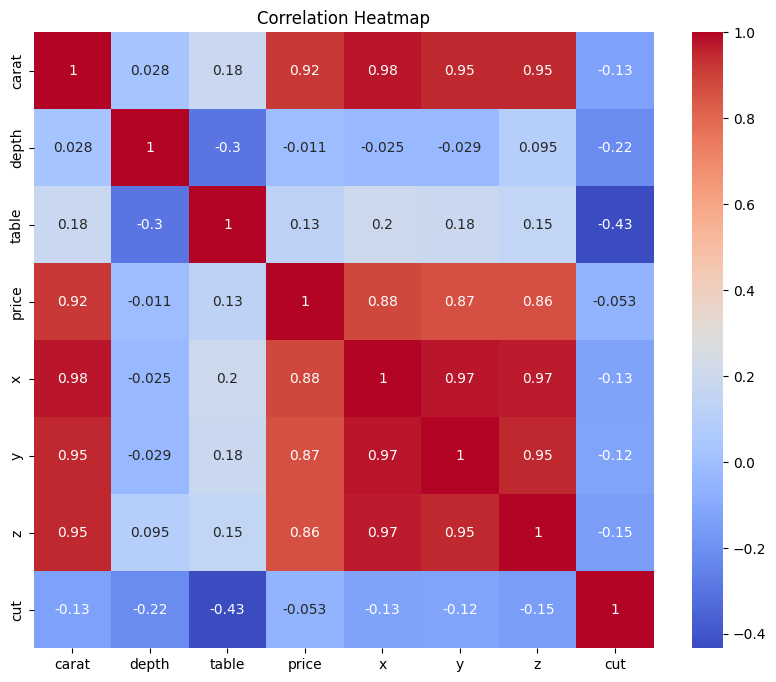

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Con este gráfico podemos observar que los atributos `x`, `y` y `z` (las dimensiones del diamante) están altamente correlacionados entre sí y con `carat` (el peso del diamante). Además, `carat` tiene una alta correlación con `price` (el precio del diamante). Esto tiene sentido, ya que los diamantes están formados de un mismo material, así que no van a haber grandes variaciones en su densidad, por lo que el peso y las dimensiones están estrechamente relacionados.

Debido a esta alta correlación podríamos considerar unificar los atributos `x`, `y` y `z` en una sola variable `volume` (el volumen del diamante), o incluso descartarlos, ya que estos están altamente relacionados con `carat`, por lo que no temeríamos perder información al hacerlo.

Al mismo tiempo podemos ver que los atributos como `depth`, `table` y `cut` tienen una relación más débil y podrían no ser predictores significativos.

## Scatter Plot

A continuación hacemos un scatter plot de las variables numéricas comparadas con `price`, la cual es la variable que deseamos predecir. Esto con el fin de analizar si existe una tendencia lineal entre los datos correlacionados y revisar el comportamiento de los datos con relación más baja.


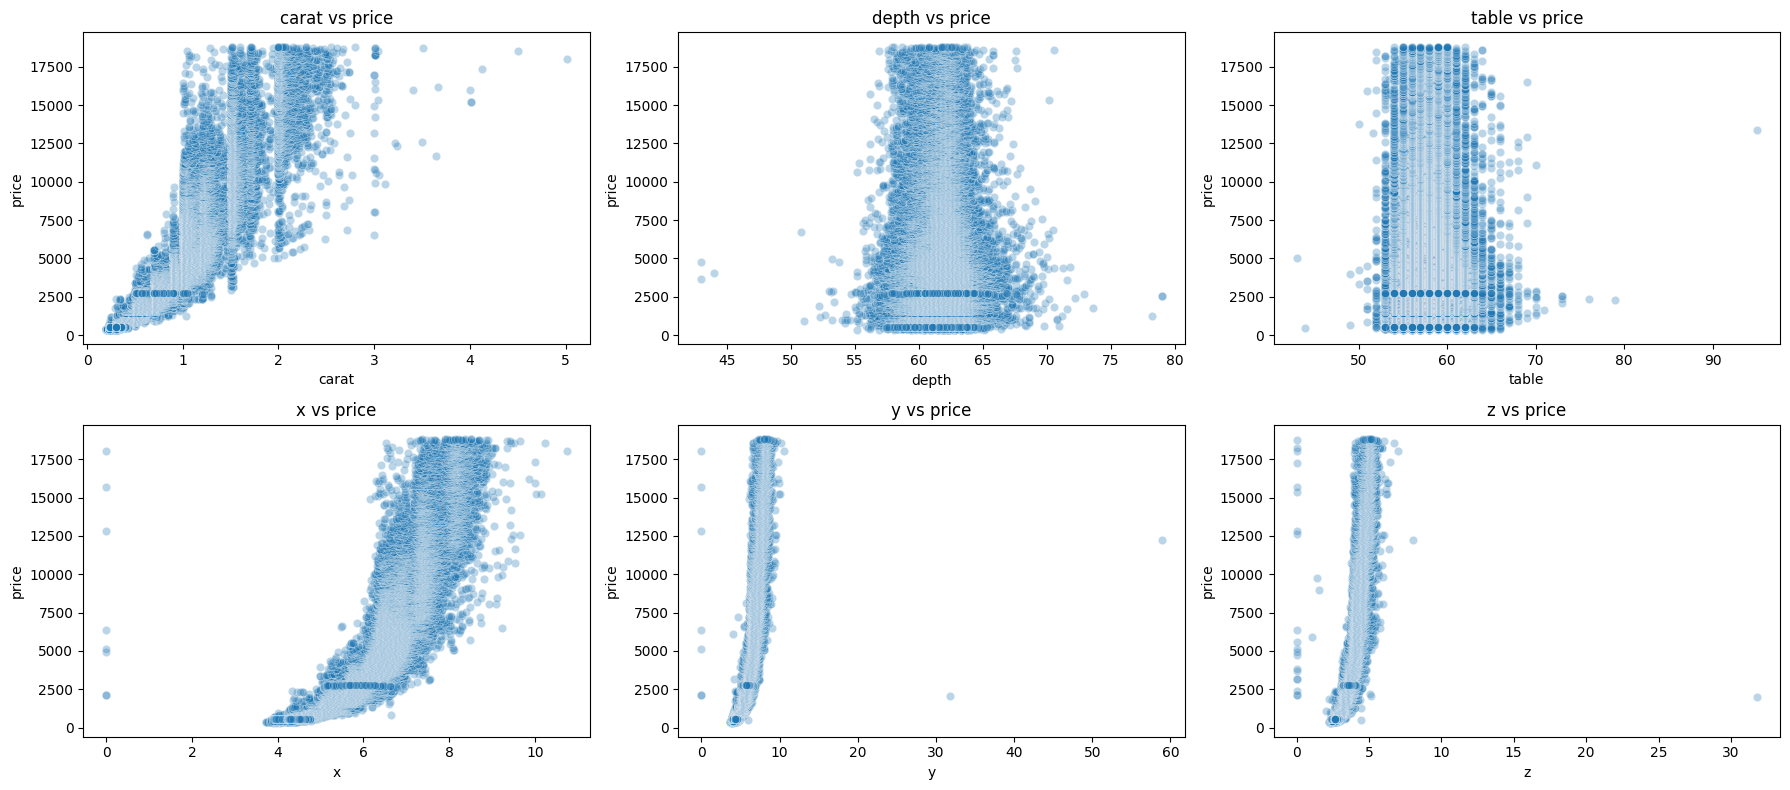

In [33]:
num_cols = df.select_dtypes(include="number").columns.drop("price")
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.scatterplot(x=col, y="price", data=df, alpha=0.3, ax=ax)
    ax.set_title(f"{col} vs price")
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
plt.tight_layout()
plt.show()

De estos gráficos se puede apreciar lo siguiente:
- `carat` presenta una correlación positiva con respecto a `price`. Tiende a dispersarse mucho en los precios más altos y se llega a un pico de aumento. Este es un buen punto para escalar los datos de `price` para rectificar la curva y aclarar la varianza.
- `x`, `y` y `z` presentan correlaciones positivas afectadas por posibles outliers y valores extraños como el 0 en sus dimensiones. Idealmente se deberían descartar esos valores.
- La correlación de `table` y `depth`, como vimos anteriormente, es muy baja y no se nota ninguna tendencia (positiva o negativa) en los datos. Se podría descartar las columnas como predictores.

## Box Plot

A continuación se muestra un box plot de `price` contra `cut`, que es una variable categórica.

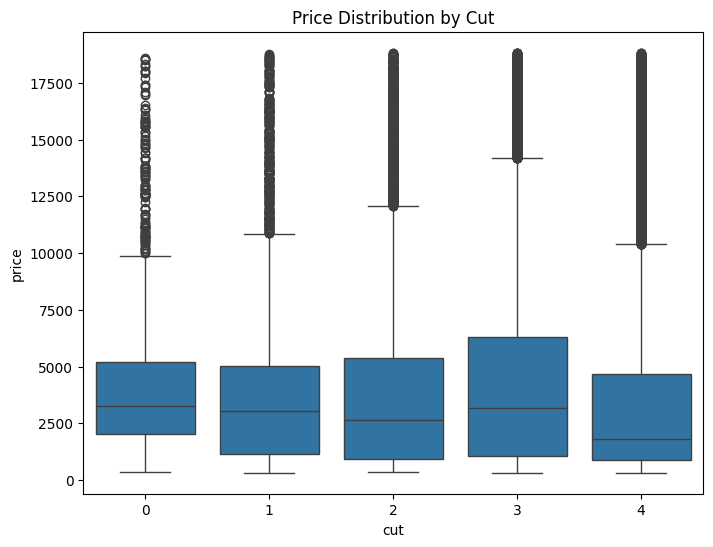

In [32]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="cut", y="price", data=df)
plt.title("Price Distribution by Cut")
plt.show()

El tipo de corte (la variable `cut`) influencia muy poco el precio y parece que solo introduce valores atípicos, ya que hay muchos diamantes con precios mayores de lo que se esperaría. No es el predictor mas fuerte, pero puede que influencie como valor categórico.

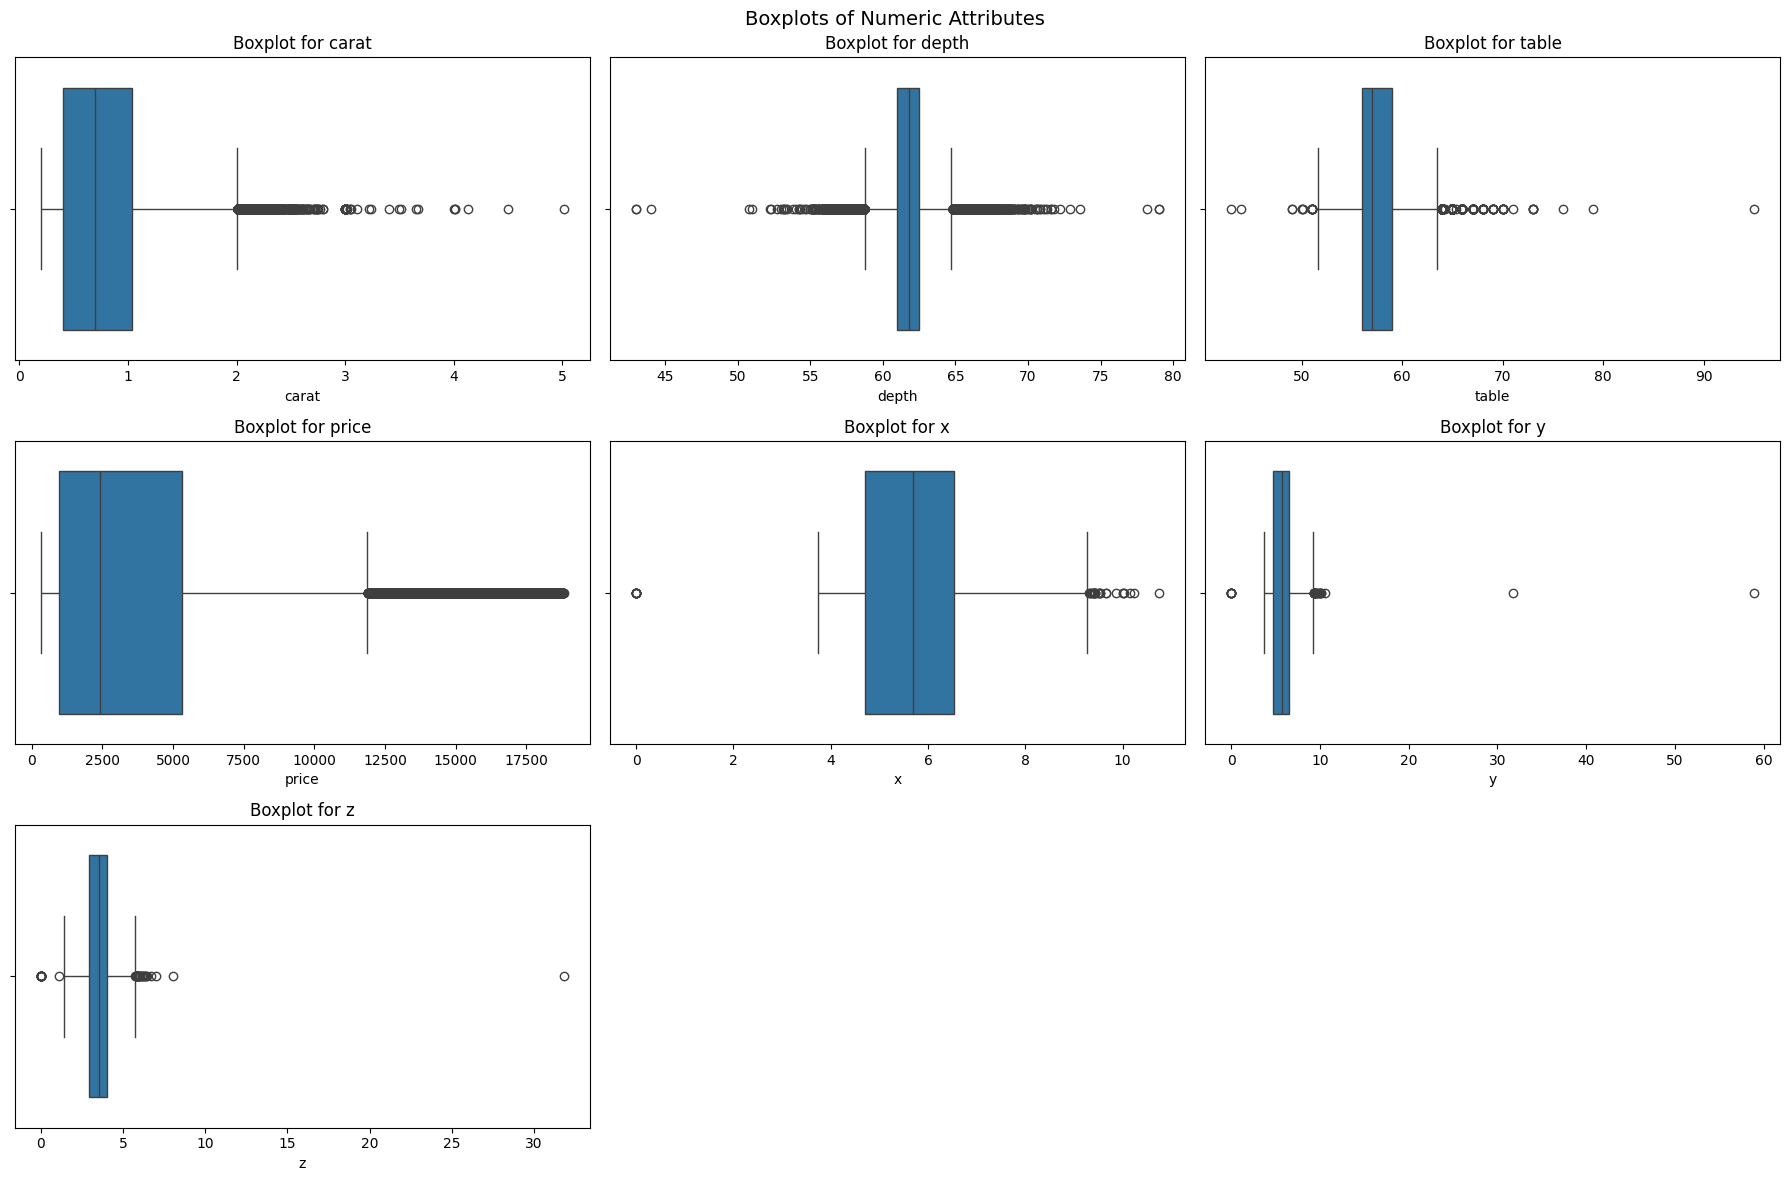

In [31]:
num_cols = df.select_dtypes(include="number").columns
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.boxplot(x=col, data=df, ax=ax, orient="h")
    ax.set_title(f"Boxplot for {col}")
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
fig.suptitle("Boxplots of Numeric Attributes", fontsize=14)
fig.tight_layout()
plt.show()

En estos _boxplots_ puede apreciar que:
- `price` y `carat` presentan colas largas hacia la derecha. La mayor parte de los diamantes es barata y hay una cola de diamantes caros. Esto implica que muchos de los outliers por IQR no son errores, sino la realidad del mercado.
- `depth` y `table` están bastante concentrados cerca de 60, con algunos outliers a ambos lados, los cuales son posibles pero hay que tratar con cautela.
- `x`, `y` y `z` muestran valores imposibles (cercanos a 0) y extremos gigantes. Estos podrían ser posibles errores y deben filtrarse.

## Histogramas

Finalmente revisamos el comportamiento de las variables mediante el uso de histogramas:

In [ ]:
df[num_cols].hist(bins=30, figsize=(10, 8))
plt.suptitle("Distribucion de Atributos")
plt.show()

Estos histogramas confirman nuestras observaciones anteriores.

### 2 (5 puntos)
- Se utilizará el modelo Train/Validation (70%) y Test (30%).
- Comente su decisión sobre los parámetros shuffle y random_state
- Separe los conjuntos de datos (70-30) (X_trainVal, X_test, y_trainVal, y_test )
- Muestre los primeros 5 registros de cada conjunto.

Para los parametros mensionados se tomaron las siguientes desiciones:

`shuffle`: El dataframe no tiene una dependencia en el orden de sus datos y como los datos mas determinantes para la prediccion tienden a valores mas bajos en benefisioso varajear las filas para evitar que el train o test solo contengan estos valores, es decir que se distribuyan mejor.

`random_state`: Debido a la naturaleza de el trabajo practico se desea tener reproductabilidad en las corridas del algoritmo, especialemnte porque se esta trabajando en grupo, por eso definir el valor del random_state es necesario para asegurar que la division sea la misma en varias corridas, se escgio el numero 42 por ser uno de los mas comunes en ejemplo de regresion.

In [ ]:
X = df.drop("price", axis=1)
y = df["price"]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)

In [ ]:
X_train_val.head(5)

In [ ]:
y_train_val.head(5)

In [ ]:
X_test.head(5)

In [ ]:
y_test.head(5)

### 3 (10 puntos)
- Preprocese los atributos (Solo deje para más adelante escalar los datos).
- Debe comentar en celdas del texto el por qué seleccionó las técnicas utilizadas.

Elimanar duplicados:
Al eliminar filas duplicadas se mejora la integridad del modelo y se evita sobrerepresentar ciertas observaciones, esto puede servir en el caso de diamantes ya que la prediccion puede ser afectada por el precio de mercado especialmente en los valores de `carat` bajos.

In [ ]:
X_train_val = X_train_val.drop_duplicates()
X_test = X_test.drop_duplicates()

y_train_val = y_train_val.loc[X_train_val.index]
y_test = y_test.loc[X_test.index]

Remosion de datos invalidos para el modelo:
Estos datos como `x,y,z` = 0 o dimensiones no realistas pueden afectar al modelo e introducir ruido

In [ ]:
valid_train = (
    (X_train_val["carat"] > 0)
    & (X_train_val["x"] > 0)
    & (X_train_val["y"] > 0)
    & (X_train_val["z"] > 0)
    & (X_train_val["depth"].between(40, 80))
    & (X_train_val["table"].between(40, 80))
)

valid_test = (
    (X_test["carat"] > 0)
    & (X_test["x"] > 0)
    & (X_test["y"] > 0)
    & (X_test["z"] > 0)
    & (X_test["depth"].between(40, 80))
    & (X_test["table"].between(40, 80))
)

# Apply filters
X_train_val = X_train_val[valid_train]
y_train_val = y_train_val[valid_train]
X_test = X_test[valid_test]
y_test = y_test[valid_test]

In [ ]:
X_train_val.head(5)

In [ ]:
y_train_val.head(5)

In [ ]:
X_test.head(5)

In [ ]:
y_test.head(5)

//TODO no se si sea necesario lo del cut, mejor veamos eso luego en el model

//TODO ver si quitamos esto de los quartiles como preprocesamiento

In [ ]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]


for col in ["x", "y", "z"]:
    df = remove_outliers_iqr(df, col)
df.head(5)

In [ ]:
for col in ["carat", "x", "y", "z"]:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=col, y="price", data=df, alpha=0.3)
    plt.title(f"{col} vs Price")
    plt.show()

In [ ]:
# df['volume'] = df['x'] * df['y'] * df['z']
df = df.drop(["x", "y", "z"], axis=1)

In [ ]:
df = df.drop(["depth", "table", "cut"], axis=1)

In [ ]:
df.head(10)

### 4 (5 puntos)
- Realice selección de atributos.
- Debe utilizar al menos una técnica para justificar su decisión (De entre los métodos: Filter, Wrapper, Embedded).
- Comente sus conclusiones.

### 1.5 (5 puntos)
- Escale los datos.
- Comente qué técnica utilizó y por qué.
- Guarde el archivo ya pre-procesado con el nombre: "'diamondsPROCESADO"

**Nota:** No olvide cómo manejará el "bias" (o agregar columna de unos, o si la implementación de los algoritmos que utilizará permiten indicarle que lo agregue).

### 1.6 (15 puntos)
Presente e implemente un diseño experimental que incluya:
- Dos algoritmos diferentes:
    - Uno será la regresión lineal de mínimos cuadrados sin regularización (OLSR).
    - Usted elegirá un método más, que no sea de los vistos en clase. Si tiene dudas de si puede o no usar algún método, puede consultar al profesor. Para el segundo método deberá elegir al menos un hiperparámetro.
    - Como el OLSR no tiene hiperparámetros, use todo el train/validation para entrenar. Para el otro método, debe usar ten-cross-validation para seleccionar al menos un hiperparámetro.
    - Debe registrar las métricas RMSE y R2. Usted decide cuál de estas dos métricas usa para seleccionar la mejor configuración (Justifique su selección).

**Nota:** Para el algoritmos seleccionado (no el OLSR) explique los parámetros que recibe según la biblioteca utilizada.

### 1.7 (5 puntos)
- Por medio de una tabla u otro método idóneo que Usted determine, resuma todos los resultados obtenidos (o la mayoría).
- Grafique comparativamente los valores del real versus el predicho (test), de cada uno de los métodos utilizados.
- Qué conclusiones finales saca sobre los métodos usados como predictores.

___

# Parte 2 - Clasificación (50 puntos)
___

### Considere lo siguiente:
1. Conjunto de datos: **cardio.csv**
2. Algunos detalles del conjunto de datos los puede ver en: <https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset>.
3. El atributo a predecir es: **cardio**.
4. Proponga al menos dos algoritmos a utilizar
5. Métricas:
    1. Accuracy
    2. Ustedes propongan una más.
6. Debe presentar en este cuaderno:
    1. Pre-procesamiento de los datos, explicando las decisiones en cada caso.
    2. Para cada uno de los algoritmos seleccionados:
        1. Explicación del algoritmo.
        2. Explicación de la implementación seleccionada y de sus parámetros (según la biblioteca).
    4. Explicación del diseño experimental por ejecutar. Recuerde que si el algoritmo requiere seleccionar hiperparámetros, hay que dividir en tres conjuntos de datos: Training, Validation, Testing (60%, 20%, 20%). Se le recomienda confirmar con el profesor cuántos y cuáles hiperparámetros validar.
    5. Programación del diseño experimental.
    6. Tablas de resultados, gráficos y conclusiones de los resultados, recomendando a su contratante cuál algoritmo utilizar, con qué configuración y por qué lo recomienda.